In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, f1_score
import matplotlib.colors as mcolors
import matplotlib as mpl

# 1. Evaluation on controlled dataset

In [29]:
annot_fever_dplaceq = "../../data/ablations/discrepancies/results/v2/FEVER-DPLACE-Q_v3_discp.csv"

In [30]:
df = pd.read_csv(annot_fever_dplaceq)

models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]
f1_results = []

for model in models:
    per_class_f1 = []
    
    for label in df["label"].unique():
        # Create binary labels (1 if this label, 0 otherwise)
        true_binary = (df["label"] == label).astype(int)
        pred_binary = (df[f"discp_{model}"] == label).astype(int)

        # Compute F1-score for this specific label
        f1 = f1_score(true_binary, pred_binary, average="binary")
        per_class_f1.append(f1)

        # Store per-class F1-score
        f1_results.append({"Label": label, "Model": model, "F1-score": f1})

    # Compute Weighted-F1 for the model
    weighted_f1 = f1_score(df["label"], df[f"discp_{model}"], average="weighted")
    f1_results.append({"Label": "Weighted-F1", "Model": model, "F1-score": weighted_f1})

# Convert results to DataFrame
f1_df = pd.DataFrame(f1_results)

# Sort models correctly
model_order = models
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

# Pivot for LaTeX output
latex_table = f1_df.pivot(index="Label", columns="Model", values="F1-score")
latex_table = latex_table[model_order]  # Ensure correct column order

# Convert to LaTeX table
latex_output = latex_table.to_latex(float_format="%.3f", caption="F1-score per Label and Weighted-F1", label="tab:f1_scores")
print(latex_output)

latex_table

\begin{table}
\caption{F1-score per Label and Weighted-F1}
\label{tab:f1_scores}
\begin{tabular}{lrrr}
\toprule
Model & qwen:32b & llama3.3:70b & gpt-4o-2024-08-06 \\
Label &  &  &  \\
\midrule
CONTRADICTION & 0.935 & 0.883 & 0.962 \\
CULTURAL_DISCREPANCY & 0.889 & 0.809 & 0.869 \\
NOT_ENOUGH_INFO & 0.825 & 0.889 & 0.889 \\
NO_DISCREPANCY & 0.980 & 0.961 & 0.942 \\
Weighted-F1 & 0.914 & 0.885 & 0.918 \\
\bottomrule
\end{tabular}
\end{table}



Model,qwen:32b,llama3.3:70b,gpt-4o-2024-08-06
Label,,,
CONTRADICTION,0.934579,0.882883,0.961538
CULTURAL_DISCREPANCY,0.888889,0.808511,0.868687
NOT_ENOUGH_INFO,0.825397,0.888889,0.888889
NO_DISCREPANCY,0.980000,0.960784,0.942308
Weighted-F1,0.913850,0.884973,0.917501


/tmp/ipykernel_1687383/3954026239.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


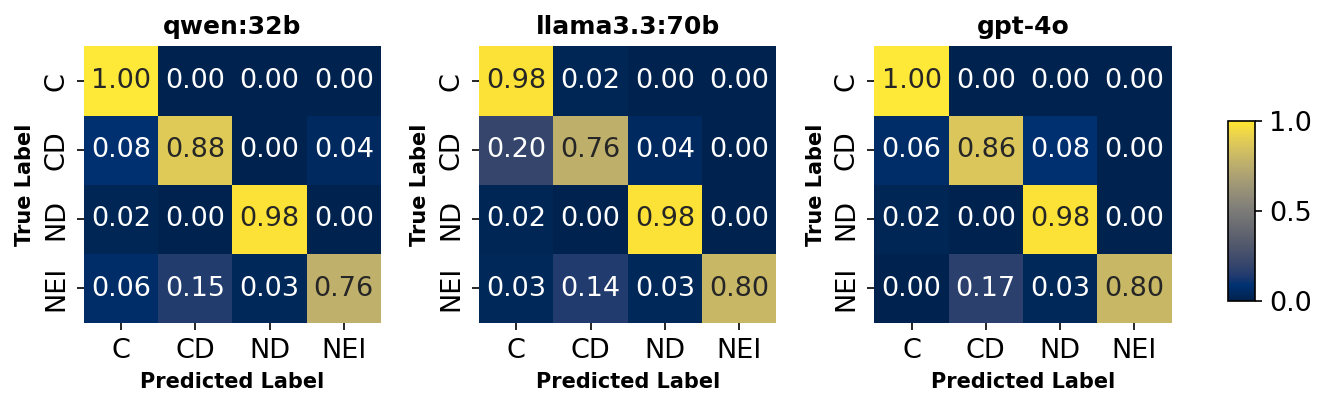

In [31]:
true_col = "label"
pred_cols = OrderedDict([
    ("qwen:32b", "discp_qwen:32b"),
    ("llama3.3:70b", "discp_llama3.3:70b"),
    ("gpt-4o-2024-08-06", "discp_gpt-4o-2024-08-06"),
])

# fixed order and pretty tick labels
order = ["CONTRADICTION", "CULTURAL_DISCREPANCY", "NO_DISCREPANCY", "NOT_ENOUGH_INFO"]
abbr = {"CONTRADICTION": "C", "CULTURAL_DISCREPANCY": "CD", "NO_DISCREPANCY": "ND", "NOT_ENOUGH_INFO": "NEI"}
true_labels = [abbr[x] for x in order]
pred_labels = true_labels  # same order for columns

def row_norm_confusion(y_true, y_pred, labels):
    ct = pd.crosstab(
        pd.Categorical(y_true, categories=labels),
        pd.Categorical(y_pred, categories=labels),
        dropna=False
    ).astype(float)
    row_sums = ct.sum(axis=1).replace(0, np.nan)
    m = (ct.T / row_sums).T.fillna(0.0)
    # return as DataFrame with pretty tick labels to pass to seaborn
    m.index = [abbr[i] for i in m.index]
    m.columns = [abbr[j] for j in m.columns]
    return m

# compute matrices for each model
models = OrderedDict()
for title, col in pred_cols.items():
    models[title] = row_norm_confusion(df[true_col], df[col], order)

# --- Plotting (your styling) ---
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
vmin, vmax = 0.0, 1.0
cmap = "cividis"  # Updated color palette

for ax, (title, matrix) in zip(axes, models.items()):
    sns.heatmap(
        matrix, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax,
        xticklabels=pred_labels, yticklabels=true_labels, ax=ax, cbar=False
    )
    title = title if title != "gpt-4o-2024-08-06" else "gpt-4o"
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted Label", fontsize=10, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=10, fontweight='bold')

# shared colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(bottom=0.25)


# optional: save
plt.savefig("../../figures_tables/confusion_fever_d_place_q_fixed.pdf", bbox_inches="tight")

plt.show()


# 2. Evaluation on controlled + ROSIE samples by humans

In [32]:
path_original = Path("../../data/ablations/discrepancies/eval_tasks/discrepancies_v5.xlsx")
df = pd.read_excel(path_original)

In [33]:
pivot = (
    df.groupby(["source", "model", "discrepancy"])
      .size()
      .unstack(fill_value=0)   # discrepancy values become columns
      .reset_index()
)

pivot


discrepancy,source,model,CONTRADICTION,CULTURAL_DISCREPANCY,NOT_ENOUGH_INFO,NO_DISCREPANCY
0,11,gpt-4o,0,0,10,10
1,11,llama3.3:70b,10,3,10,10
2,11,qwen:32b,8,4,10,10
3,15,gpt-4o,0,0,10,10
4,15,llama3.3:70b,13,6,10,10
5,15,qwen:32b,10,6,10,10
6,FEVER-DPLACE-Q,synthetic,50,50,35,50


In [34]:
path_task = Path("../../data/ablations/discrepancies/results/v2")
path_ann1 = path_task / "discrepancies_v5_ann_a.xlsx"
path_ann2 = path_task / "discrepancies_v5_ann_d.xlsx"
path_ann3 = path_task / "discrepancies_v5_ann_p.xlsx"

In [35]:
# this can vary depending on the annotator (they sometimes don't follow instructions)
df_ann=pd.read_excel(path_ann1)
print(df_ann.label.unique())
print(f"number of CONTRADICTION: {len(df_ann[df_ann.label == 'CONTRADICTION'])/len(df_ann)}")
print(f"number of NO_DISCREPANCY: {len(df_ann[df_ann.label == 'NO_DISCREPANCY'])/len(df_ann)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann[df_ann.label == 'CULTURAL_DISCREPANCY'])/len(df_ann)}")

['CULTURAL_DISCREPANCY' 'NO_DISCREPANCY' 'CONTRADICTION' 'NOT_ENOUGH_INFO']
number of CONTRADICTION: 0.2410958904109589
number of NO_DISCREPANCY: 0.3561643835616438
number of CULTURAL_DISCREPANCY: 0.14246575342465753


In [36]:
df_ann2 = pd.read_excel(path_ann2)
df_ann2["label2"] = df_ann2["label"]
print(df_ann2.label.unique())
print(f"number of CONTRADICTION: {len(df_ann2[df_ann2.label2 == 'CONTRADICTION'])/len(df_ann2)}")
print(f"number of NO_DISCREPANCY: {len(df_ann2[df_ann2.label2 == 'NO_DISCREPANCY'])/len(df_ann2)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann2[df_ann2.label2 == 'CULTURAL_DISCREPANCY'])/len(df_ann2)}")

['CULTURAL_DISCREPANCY' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO' 'CONTRADICTION']
number of CONTRADICTION: 0.1917808219178082
number of NO_DISCREPANCY: 0.3506849315068493
number of CULTURAL_DISCREPANCY: 0.19452054794520549


In [37]:
df_ann3 = pd.read_excel(path_ann3)
df_ann3["label3"] = df_ann3["label"]
print(df_ann3.label.unique())
print(f"number of CONTRADICTION: {len(df_ann3[df_ann3.label3 == 'CONTRADICTION'])/len(df_ann3)}")
print(f"number of NO_DISCREPANCY: {len(df_ann3[df_ann3.label3 == 'NO_DISCREPANCY'])/len(df_ann3)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann3[df_ann3.label3 == 'CULTURAL_DISCREPANCY'])/len(df_ann3)}")

['CONTRADICTION' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO' 'CULTURAL_DISCREPANCY']
number of CONTRADICTION: 0.29863013698630136
number of NO_DISCREPANCY: 0.38082191780821917
number of CULTURAL_DISCREPANCY: 0.06027397260273973


In [38]:
df_ann = df_ann.merge(df_ann2[["id_discr", "label2"]], on="id_discr", how="left")
df_ann = df_ann.merge(df_ann3[["id_discr", "label3"]], on="id_discr", how="left")
df_ann

,id_discr,question,answer_t,answer_s,label,label2,label3
0,0,Is the initial marital residence typically est...,"Yes, it is often avunculocal, residing with or...","No, it is ambilocal, with residence optionally...",CULTURAL_DISCREPANCY,CULTURAL_DISCREPANCY,CONTRADICTION
1,1,Is the risk of serious complications from amni...,"YES, the risk of serious complications from am...","YES, the risk of serious complications from am...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
2,2,Has placental vasoconstriction been observed i...,"YES, placental vasoconstriction has been obser...","YES, placental vasoconstriction has been obser...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
3,3,Did Quentin Tarantino make a movie?,"Yes, Quentin Tarantino made a movie.","Yes, Quentin Tarantino made several movies, in...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
4,4,Does erythroblastosis fetalis refer to a condi...,"YES, erythroblastosis fetalis refers to a cond...","NO, erythroblastosis fetalis specifically refe...",CONTRADICTION,CULTURAL_DISCREPANCY,CONTRADICTION
...,...,...,...,...,...,...,...
360,360,Should you contact your provider if you experi...,"YES, you should contact your provider if you e...","YES, you should contact your provider if you e...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
361,361,Does neonatal respiratory distress syndrome (R...,"YES, neonatal respiratory distress syndrome (R...","YES, neonatal respiratory distress syndrome (R...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY
362,362,Has Emily Blunt yet to appear in a film adapte...,"Yes, Emily Blunt has yet to appear in a film a...","No, Emily Blunt appeared in ""Salmon Fishing in...",CONTRADICTION,CONTRADICTION,CONTRADICTION
363,363,Is animal husbandry typically performed by mal...,No data is available on this specialization.,"Yes, it is primarily performed by males, with ...",NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO


In [39]:
df_ann.columns

Index(['id_discr', 'question', 'answer_t', 'answer_s', 'label', 'label2',
       'label3'],
      dtype='object')

In [40]:
# drop duplicates by question, answer_text
df_ann = df_ann.drop_duplicates(subset=["question", "answer_t"])

df_ann = df_ann.merge(df[["id_discr", "model", "discrepancy", "reason"]], on="id_discr", how="left")
df_ann["model"] = df_ann["model"].fillna("synthetic")
df_ann["model"] = df_ann["model"].apply(lambda x: x.replace('gpt-4o-2024-08-06', 'gpt-4o'))

df_ann["agree"] = df_ann["label"] == df_ann["discrepancy"]
df_ann["agree2"] = df_ann["label2"] == df_ann["discrepancy"]
df_ann["agree3"] = df_ann["label3"] == df_ann["discrepancy"]

keep_cols = [col for col in df_ann if not col.startswith("Unnamed")]
df_ann = df_ann[keep_cols]

df_summary = df_ann.groupby(["model", "discrepancy"]).agg(
    agree_count=("agree", "sum"),    
    agree2_count=("agree2", "sum"),  
    agree3_count=("agree3", "sum"),
    total=("agree", "count")
).reset_index()

df_summary["agree_ratio"] = df_summary["agree_count"] / df_summary["total"]
df_summary["agree2_ratio"] = df_summary["agree2_count"] / df_summary["total"]
df_summary["agree3_ratio"] = df_summary["agree3_count"] / df_summary["total"]


df_summary

,model,discrepancy,agree_count,agree2_count,agree3_count,total,agree_ratio,agree2_ratio,agree3_ratio
0,gpt-4o,NOT_ENOUGH_INFO,20,20,20,20,1.000000,1.000000,1.000000
1,gpt-4o,NO_DISCREPANCY,20,20,20,20,1.000000,1.000000,1.000000
2,llama3.3:70b,CONTRADICTION,22,16,12,23,0.956522,0.695652,0.521739
3,llama3.3:70b,CULTURAL_DISCREPANCY,0,2,0,9,0.000000,0.222222,0.000000
4,llama3.3:70b,NOT_ENOUGH_INFO,20,20,20,20,1.000000,1.000000,1.000000
5,llama3.3:70b,NO_DISCREPANCY,19,18,19,20,0.950000,0.900000,0.950000
6,qwen:32b,CONTRADICTION,10,11,10,17,0.588235,0.647059,0.588235
7,qwen:32b,CULTURAL_DISCREPANCY,0,0,1,10,0.000000,0.000000,0.100000
8,qwen:32b,NOT_ENOUGH_INFO,20,20,20,20,1.000000,1.000000,1.000000
9,qwen:32b,NO_DISCREPANCY,20,19,18,20,1.000000,0.950000,0.900000


## 2.1. Agreement

In [41]:
inter_annotator_kappa = cohen_kappa_score(df_ann["label"], df_ann["label2"])

print(f"Inter-annotator Cohen's Kappa: {inter_annotator_kappa:.3f}")

Inter-annotator Cohen's Kappa: 0.857


In [42]:
pairs = [("label","label2"), ("label","label3"), ("label2","label3")]

pair_kappas = {}
pair_ns = {}

for a, b in pairs:
    sub = df_ann[[a, b]].dropna()   # solo filas con ambas etiquetas presentes
    if sub.empty:
        continue
    k = cohen_kappa_score(sub[a], sub[b])
    pair_kappas[f"{a}-{b}"] = k
    pair_ns[f"{a}-{b}"] = len(sub)

# Promedio simple y (opcional) ponderado por nº de ítems válidos
macro = np.mean(list(pair_kappas.values()))
weighted = np.average(list(pair_kappas.values()), weights=list(pair_ns.values()))

print("Kappas pareadas:", pair_kappas)
print(f"Promedio (macro): {macro:.3f}")
print(f"Promedio ponderado: {weighted:.3f}")


Kappas pareadas: {'label-label2': 0.8574108818011257, 'label-label3': 0.7198848841989859, 'label2-label3': 0.6529165457485179}
Promedio (macro): 0.743
Promedio ponderado: 0.743


In [43]:
from statsmodels.stats.inter_rater import fleiss_kappa

def fleiss_kappa_from_labels(df, rater_cols):
    """
    df[rater_cols]: columnas con etiquetas nominales (p.ej., 4 clases).
    Filtra a filas completas (sin NaN) para que todos los ítems tengan el mismo nº de anotadores.
    Devuelve (kappa, n_items, classes).
    """
    sub = df[rater_cols].dropna(how="any").astype(str)
    if sub.empty:
        return np.nan, 0, []
    # Lista ordenada de clases observadas
    classes = sorted(pd.unique(sub.values.ravel()))
    cls_to_idx = {c: i for i, c in enumerate(classes)}

    # Matriz de conteos (n_items x n_classes)
    counts = np.zeros((len(sub), len(classes)), dtype=int)
    for i, row in enumerate(sub.itertuples(index=False)):
        for lab in row:                       # recorre los 3 votos
            counts[i, cls_to_idx[lab]] += 1   # suma en la clase correspondiente

    kappa = fleiss_kappa(counts)
    return float(kappa), len(sub), classes

kappa_fleiss, n_items, classes = fleiss_kappa_from_labels(df_ann, ["label","label2","label3"])
print(f"Fleiss' κ (3 anotadores, {n_items} ítems, clases={classes}): {kappa_fleiss:.3f}")

Fleiss' κ (3 anotadores, 364 ítems, clases=['CONTRADICTION', 'CULTURAL_DISCREPANCY', 'NOT_ENOUGH_INFO', 'NO_DISCREPANCY']): 0.743


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

agreement_results = []

for (model, category), group in df_ann.groupby(["model", "discrepancy"]):
    y_true1 = (group["label"]  == category).astype(int)
    y_true2 = (group["label2"] == category).astype(int)
    y_true3 = (group["label3"] == category).astype(int)
    y_pred  = (group["discrepancy"] == category).astype(int) 

    f1_label  = f1_score(y_true1, y_pred, zero_division=0)
    f1_label2 = f1_score(y_true2, y_pred, zero_division=0)
    f1_label3 = f1_score(y_true3, y_pred, zero_division=0)

    agreement_results.append({
        "model": model,
        "category": category,
        "f1_label": f1_label,
        "f1_label2": f1_label2,
        "f1_label3": f1_label3,
        "count": len(group)
    })

agreement_by_category_df = pd.DataFrame(agreement_results)
agreement_by_category_df

,model,category,f1_label,f1_label2,f1_label3,count
0,gpt-4o,NOT_ENOUGH_INFO,1.000000,1.000000,1.000000,20
1,gpt-4o,NO_DISCREPANCY,1.000000,1.000000,1.000000,20
2,llama3.3:70b,CONTRADICTION,0.977778,0.820513,0.685714,23
3,llama3.3:70b,CULTURAL_DISCREPANCY,0.000000,0.363636,0.000000,9
4,llama3.3:70b,NOT_ENOUGH_INFO,1.000000,1.000000,1.000000,20
5,llama3.3:70b,NO_DISCREPANCY,0.974359,0.947368,0.974359,20
6,qwen:32b,CONTRADICTION,0.740741,0.785714,0.740741,17
7,qwen:32b,CULTURAL_DISCREPANCY,0.000000,0.000000,0.181818,10
8,qwen:32b,NOT_ENOUGH_INFO,1.000000,1.000000,1.000000,20
9,qwen:32b,NO_DISCREPANCY,1.000000,0.974359,0.947368,20


## 2.2. Discrepancy category figure

Agreement F1 is computed per predicted category as the binary F1 between the model’s predictions and each annotator’s gold labels, averaged across annotators.

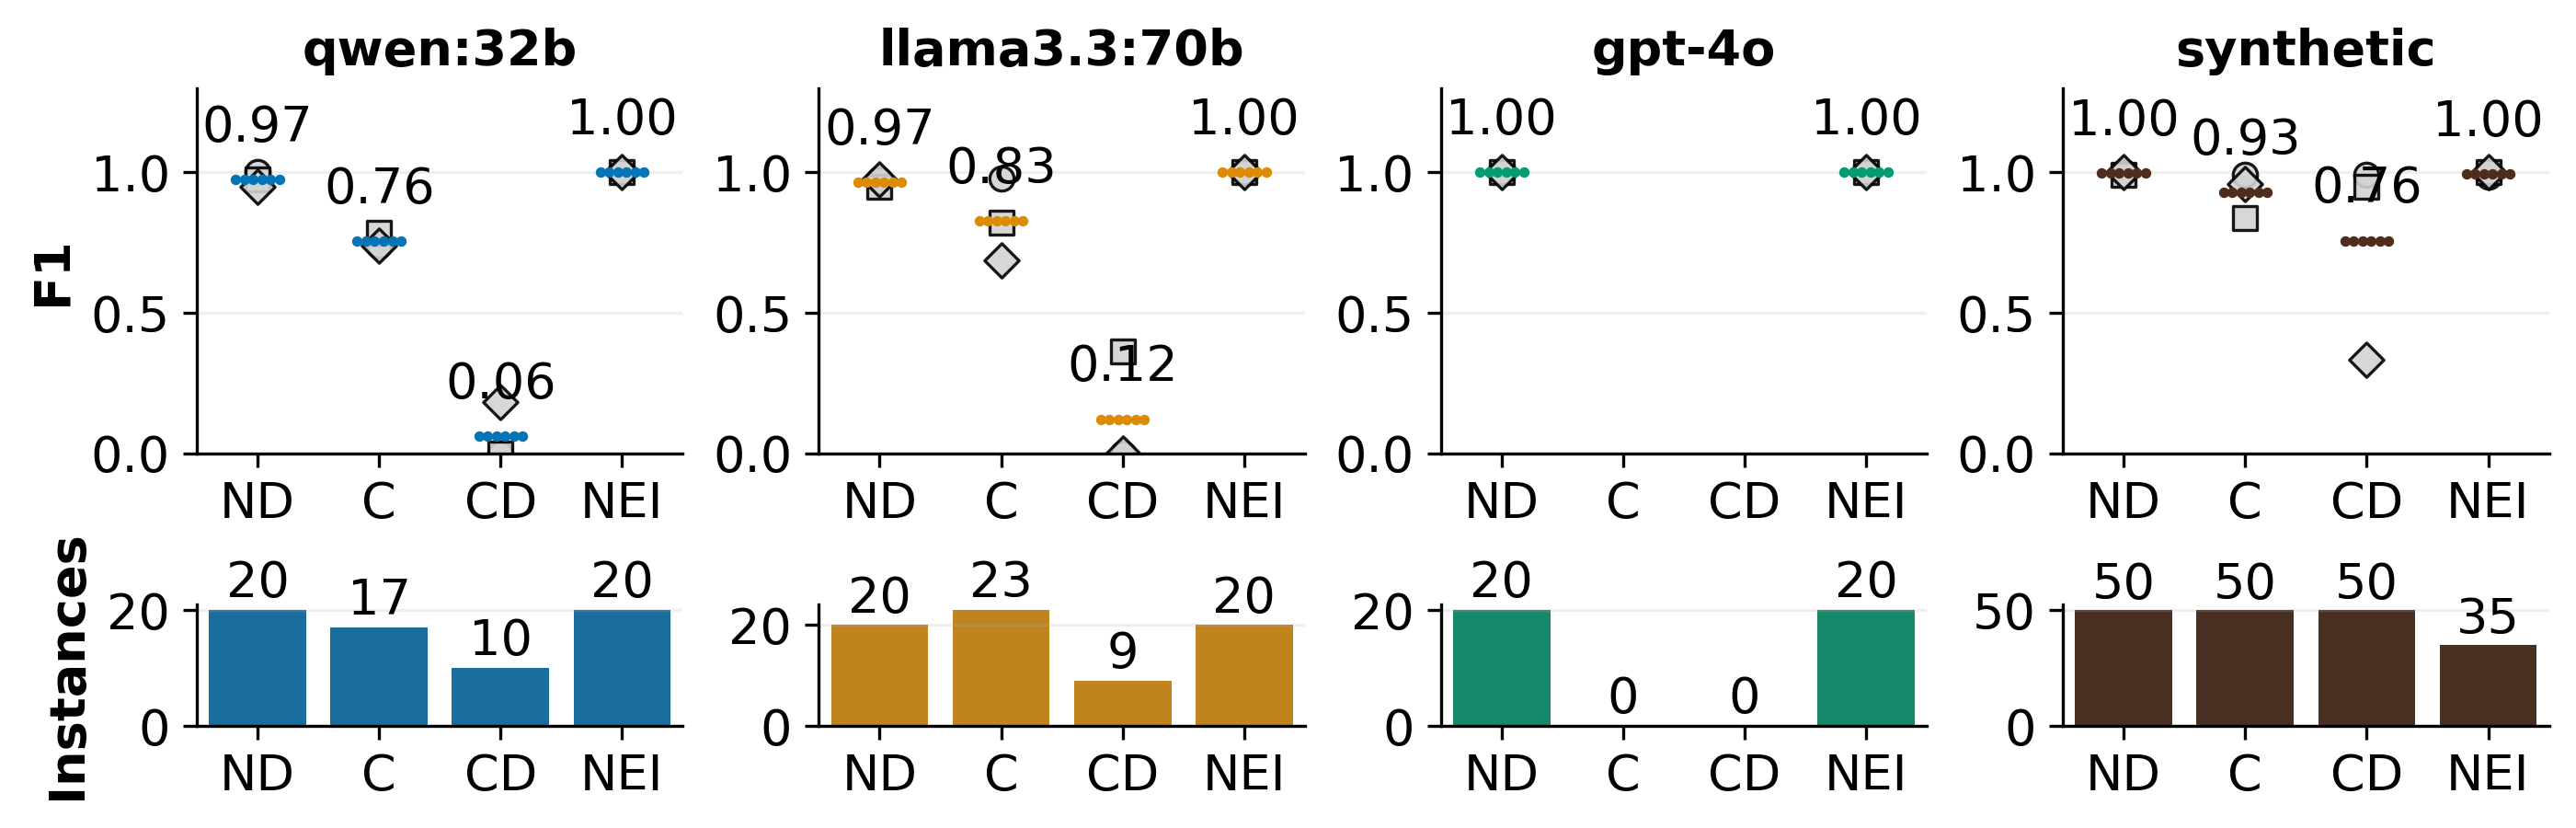

In [45]:

mpl.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 13,
    "axes.labelsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

category_labels = {
    "NO_DISCREPANCY": "ND",
    "CONTRADICTION": "C",
    "CULTURAL_DISCREPANCY": "CD",
    "NOT_ENOUGH_INFO": "NEI"
}
agreement_by_category_df["category"] = (
    agreement_by_category_df["category"].replace(category_labels)
)


cat_order = ["ND", "C", "CD", "NEI"]
agreement_by_category_df["category"] = pd.Categorical(
    agreement_by_category_df["category"],
    categories=cat_order,
    ordered=True
)

desired_model_order = [
    "qwen:32b", "llama3.3:70b", "gpt-4o", "synthetic" 
]
model_color_map = {
    "qwen:32b": "#0474b4",  
    "llama3.3:70b": "#db8b04",  
    "gpt-4o": "#049b73", 
    "synthetic": "#4f2c1c",  
}
present_models = agreement_by_category_df["model"].dropna().unique().tolist()
full_model_order = (
    [m for m in desired_model_order if m in present_models] +
    [m for m in present_models if m not in desired_model_order]
)

fallback_cycle = sns.color_palette("tab10", n_colors=max(10, len(full_model_order)))
fallback_map = {m: fallback_cycle[i % len(fallback_cycle)] for i, m in enumerate(full_model_order)}

palette_map = {
    m: mcolors.to_rgba(model_color_map[m]) if m in model_color_map else fallback_map[m]
    for m in full_model_order
}

def near_mean_text_y(mu, other_ys, ylim,
                     min_gap=0.03,     # min clearance from any dot/mean
                     edge_pad=0.02,    # distance from axis edge
                     label_offset=0.02 # extra nudge so text doesn't kiss the dots
                     ):
    lo, hi = ylim
    closest = min(abs(mu - y) for y in ([mu] + list(other_ys)))
    gap = max(min_gap, closest + 0.01)

    y_above = mu + gap + label_offset
    if y_above <= hi - edge_pad:
        return y_above, "bottom"

    y_below = mu - gap - label_offset
    y_below = max(y_below, lo + edge_pad)
    return y_below, "top"


fig = plt.figure(figsize=(11, 3), dpi=300)
gs = fig.add_gridspec(
    nrows=2, ncols=len(full_model_order),
    height_ratios=[3, 1], hspace=0.62, wspace=0.28
)

annotator_cols = ["f1_label", "f1_label2", "f1_label3"]
markers = ["o", "s", "D"]  # circle, square, diamond

legend_handles, legend_labels = None, None

for j, m in enumerate(full_model_order):
    ax_top = fig.add_subplot(gs[0, j])
    ax_bot = fig.add_subplot(gs[1, j], sharex=ax_top)

    dfm = (agreement_by_category_df
           .query("model == @m")
           .set_index("category")
           .reindex(cat_order))

    x = np.arange(len(cat_order))

    # annotator dots
    for col, marker in zip(annotator_cols, markers):
        ax_top.scatter(
            x, dfm[col],
            s=40, alpha=0.9,
            facecolor="lightgray", edgecolor="black",
            marker=marker, linewidth=0.8, zorder=2,
            label=col if j == 0 else None
        )

    # mean per category
    dfm["f1_mean"] = dfm[annotator_cols].mean(axis=1)
    mean_color = palette_map[m]

    # dynamic ylim
    ymax_points = max(dfm[annotator_cols].max().max(), dfm["f1_mean"].max())
    yhi = min(1.30, max(1.0, ymax_points + 0.3))
    ylim = (0.0, yhi)
    ax_top.set_ylim(*ylim)

    # draw means + labels
    for xi, (row_idx, row) in zip(x, dfm.iterrows()):
        mu = row["f1_mean"]
        offsets = np.linspace(-0.18, 0.18, 6)
        ax_top.scatter(
            xi + offsets, [mu]*len(offsets),
            s=12, color=mean_color, marker=".", zorder=3,
            label="mean" if (j==0 and xi==0) else None
        )

        other_ys = [row[c] for c in annotator_cols if pd.notna(row[c])]
        y_txt, va = near_mean_text_y(
            mu, other_ys, ylim=ylim,
            min_gap=0.03, edge_pad=0.02,
            label_offset=0.07
        )

        ax_top.text(
            xi, y_txt, f"{mu:.2f}",
            ha="center", va=va, fontsize=13,
            color="black", zorder=4, clip_on=True
        )

    ax_top.set_title(m, fontweight="bold")
    ax_top.set_xticks(x, cat_order)
    ax_top.set_ylabel("F1" if j == 0 else "", fontweight="bold")
    ax_top.grid(axis="y", alpha=.2)

    # counts
    dfm_counts = dfm.reset_index().fillna({"count": 0})
    sns.barplot(
        data=dfm_counts, x="category", y="count",
        order=cat_order, ax=ax_bot,
        color=mcolors.to_rgba(mean_color, alpha=.55)
    )
    for p, n in zip(ax_bot.patches, dfm_counts["count"].tolist()):
        ax_bot.text(p.get_x()+p.get_width()/2,
                    p.get_height()+0.5, int(n),
                    ha="center", va="bottom", fontsize=13)

    ax_bot.set_ylabel("Instances" if j == 0 else "", fontweight="bold")
    ax_bot.grid(axis="y", alpha=.2)

    if j == 0:
        legend_handles, legend_labels = ax_top.get_legend_handles_labels()

for ax in fig.axes:
    sns.despine(ax=ax)
    ax.set_xlabel("")    


plt.savefig("../../figures_tables/mind_ablation_discrepancy_evaluation_counts.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [46]:
df_ann[df_ann.question.str.contains("antibiotic treatment")]

,id_discr,question,answer_t,answer_s,label,label2,label3,model,discrepancy,reason,agree,agree2,agree3
253,253,Is it necessary for a child with impetigo to w...,"NO, it is not necessary for a child with impet...","NO, it is not necessary for a child with impet...",NO_DISCREPANCY,NO_DISCREPANCY,NO_DISCREPANCY,llama3.3:70b,CULTURAL_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that it is no...,False,False,False


In [47]:
df_ann[df_ann.question.str.contains("Are all newborns required to undergo cardiac screening tests?")]

,id_discr,question,answer_t,answer_s,label,label2,label3,model,discrepancy,reason,agree,agree2,agree3
227,227,Are all newborns required to undergo cardiac s...,"NO, not all newborns are required to undergo c...","YES, all newborns are required to undergo card...",CONTRADICTION,CONTRADICTION,CONTRADICTION,llama3.3:70b,CULTURAL_DISCREPANCY,The answers provide information that seems con...,False,False,False


# 3. Analysis of discrepancies detected in ROSIE

## 3.1. Part 1 (QUORA)

In [48]:
paths_final = [
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc15_complete/answers/questions_topic_15_qwen:32b_23400_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11_complete/answers/questions_topic_11_qwen:32b_14300_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc24_complete/answers/questions_topic_24_qwen:32b_18900_results_model30tpc_thr__dynamic.parquet",
]

all_ = []
for path in paths_final:
    df = pd.read_parquet(path)
    tpc= path.split("_tpc")[-1].split("_")[0]
    df["topic"]=tpc

    # cleaning 
    df.loc[df['answer_t'].str.contains("cannot answer the question given the context", na=False), 'discrepancy'] = "NOT_ENOUGH_INFO"
    df.loc[df["answer_t"] == "I cannot answer given the context.", ["discrepancy"]] = "NOT_ENOUGH_INFO"
    df.loc[df["discrepancy"] == "TYPE: NO_", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO_ONGOING_DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: CULTURAL_ DISCREPANCY", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if we consider that slight variations in recommendations might exist due to cultural influences or different parenting practices, though it's a weak case for this category)", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if you consider the slight difference in number of exposures as stemming from different studies or expert opinions)", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "TYPE: CULTURAL_", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ DISCREPANCY", "NO_DISCREPANCY")
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ENOUGH_INFO", "NOT_ENOUGH_INFO")
    df["discrepancy"] = df["discrepancy"].str.replace("CULTURAL_ DISCREPANCY", "CULTURAL_DISCREPANCY")
    
    all_.append(df)

df = pd.concat(all_)
valid_values = {"CONTRADICTION", "NO_DISCREPANCY", "CULTURAL_DISCREPANCY", "NOT_ENOUGH_INFO"}
df = df[df["discrepancy"].isin(valid_values)]
print(df.discrepancy.unique())

print(f"Original length: {len(df)}")

df = df.drop_duplicates(subset=["question", "passage_t"])
print(f"Deduplicated length: {len(df)}")

['NOT_ENOUGH_INFO' 'NO_DISCREPANCY' 'CULTURAL_DISCREPANCY' 'CONTRADICTION']
Original length: 258044
Deduplicated length: 129022


In [49]:
# question-passage_t with discrepancy=NOT_ENOUGH_INFO
print(f"Number of unique NOT_ENOUGH_INFO per topic:")
df_nei = df[df.discrepancy=="NOT_ENOUGH_INFO"]
print(df_nei.groupby("topic").size())

print("\n Number of unique question per topic:")
print(df.groupby("topic")["question"].nunique())

discrepancy_counts = df.groupby("topic")["discrepancy"].value_counts().unstack().fillna(0)
print("\n Discrepancy counts per topic:")
print(discrepancy_counts)

Number of unique NOT_ENOUGH_INFO per topic:
topic
11    41426
15    42094
24    37070
dtype: int64

 Number of unique question per topic:
topic
11    4460
15    4474
24    3991
Name: question, dtype: int64

 Discrepancy counts per topic:
discrepancy  CONTRADICTION  CULTURAL_DISCREPANCY  NOT_ENOUGH_INFO  \
topic                                                               
11                      75                    66            41426   
15                      72                   127            42094   
24                      40                   206            37070   

discrepancy  NO_DISCREPANCY  
topic                        
11                     2997  
15                     2342  
24                     2507  


## 3.2. BGE-M3

In [50]:
import re
import unicodedata
from typing import Optional

"""This is only needed for older executions of MIND; in the new ones we filter out non-yes/no questions during the pipeleine execution.
"""
def _normalize(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"^[\s\-\–\—\•\"'“”‘’«»]+", "", s)
    return s

_aux = ("is","are","am","was","were","do","does","did","has","have","had",
        "can","could","will","would","shall","should","may","might","must")
_aux_re = re.compile(rf"^\W*(?:{'|'.join(_aux)})\b", re.IGNORECASE)

_followup_openers = ("and", "but", "or", "so")

_DOC = r"(?:study|survey|report|document|guidance|paper|article|memo|white\s*paper|brief|dataset|discussion|section|appendix|table|figure|results?)"
_VERB = r"(?:include|mention|provide|state|say|note|discuss|address|cover|contain|list|describe|reference|present|report|indicate|summarize|focus)"
_PART = r"(?:included|mentioned|provided|stated|noted|discussed|addressed|covered|contained|listed|described|referenced|presented|reported|indicated|summarized|focused)"

_P1 = rf"\baccording to (?:the |this |that )?(?:results?|{_DOC})\b"
_P2 = rf"\b(?:do|does|did|has|have|had)\s+(?:(?:the|this|that|these|those)\s+)?{_DOC}\s+{_VERB}\b"
_P3 = rf"\b(?:in|within|from)\s+(?:(?:the|this|that)\s+)?{_DOC}\b"
_P4 = rf"\b(?:selected|surveyed|polled|sampled|enrolled)\s+(?:respondents?|participants?|subjects?)\b"
_P5 = rf"\bdid\s+(?:the\s+)?(?:study|survey)\b"
_P6 = rf"\bresults?\b.*\b{_PART}\b|\b{_DOC}\b.*\b{_PART}\b"
_study_like_re = re.compile(rf"(?:{_P1}|{_P2}|{_P3}|{_P4}|{_P5}|{_P6})", re.IGNORECASE)

def clean_yesno_question(q: Optional[str]) -> Optional[str]:
    if not isinstance(q, str) or not q.strip():
        return None
    q = _normalize(q)

    m = _aux_re.match(q)
    if not m:
        return None
    q = q[m.start():]

    if not q.endswith("?"):
        return None
    if len(q.split()) < 3:
        return None
    if q.lower().startswith(_followup_openers):
        return None

    if _study_like_re.search(q):
        return None

    return q

In [51]:
paths = {
    11: "../../data/mind_runs/rosie/v2/results/results_topic_11_189.parquet",
    15: "../../data/mind_runs/rosie/v2/results/results_topic_15_375.parquet",
    24: "../../data/mind_runs/rosie/v2/results/results_topic_24_154.parquet",
}

all_ = []
for tpc, path in paths.items():
    df_r = pd.read_parquet(path)
    all_.append(df_r)
df_r = pd.concat(all_)
print(df_r.columns)

print(f"Initial df_r length: {len(df_r)}")
# delete duplicates where question_id and target are the same
df_r["question_norm"] = df_r["question"].map(_normalize)
#df_r = df_r.drop_duplicates(subset=["question", "target_chunk"])
subset_cols = ["question_norm", "source_chunk_id", "target_chunk_id"]
df_r = df_r.drop_duplicates(subset=subset_cols, keep="first")
print(f"After dropping duplicates by question and target: {len(df_r)}")

# drop question_norm
df_r = df_r.drop(columns=["question_norm"])

# remove bad questions
df_r["question"] = df_r["question"].apply(clean_yesno_question)
df_r = df_r.dropna(subset=["question"])

print(f"After cleaning questions: {len(df_r)}")

# print number of unique source_id per topic
for tpc in paths.keys(): 
    n = df_r[df_r.topic == tpc]["source_chunk_id"].nunique()
    print(f"Topic {tpc}: {n} unique source_id")
    
# print number of instances per label per topic
print("Label distribution per topic:")
for tpc in paths.keys(): 
    counts = df_r[df_r.topic == tpc]["label"].value_counts()
    print(f"Topic {tpc}:\n{counts}\n")
    
# calculat average of neis across topics
nei_counts = []
for tpc in paths.keys(): 
    n_nei = df_r[(df_r.topic == tpc) & (df_r.label == "NOT_ENOUGH_INFO")].shape[0]
    n_total = df_r[df_r.topic == tpc].shape[0]
    nei_counts.append(n_total)
avg_nei = np.mean(nei_counts)
print(f"Average NOT_ENOUGH_INFO ratio across topics: {avg_nei:.3f}")

# for each topic, keep rows where label is "CONTRADICTION" or "CULTURAL_DISCREPANCY", and sample and equal number of "NO_DISCREPANCY"
balanced_dfs = []
for tpc in paths.keys(): 
    df_sub = df_r[df_r.topic == tpc]
    df_cd = df_sub[df_sub.label.isin(["CONTRADICTION", "CULTURAL_DISCREPANCY"])]
    n_cd = len(df_cd)
    df_nd = df_sub[df_sub.label == "NO_DISCREPANCY"].sample(n=n_cd, random_state=42)
    balanced_df = pd.concat([df_cd, df_nd])
    balanced_dfs.append(balanced_df)
    print(f"Topic {tpc}: {len(balanced_df)} instances ({len(df_cd)} with discrepancies, {len(df_nd)} without)")
df_balanced = pd.concat(balanced_dfs)

def get_formatted_question_id(row):
    topic = row["topic"]
    qid = row["question_id"]
    return f"TPC_{topic}_{qid}"


df_balanced["question_id"] = df_balanced.apply(get_formatted_question_id, axis=1)
print(f"Total balanced df length: {len(df_balanced)}")

#df_balanced.to_excel("../../data/mind_runs/rosie/results/rosie_mind_v3.xlsx", index=False)

df_balanced

Index(['topic', 'question_id', 'question', 'subquery', 'source_chunk',
       'target_chunk', 'a_s', 'a_t', 'label', 'reason', 'source_chunk_id',
       'target_chunk_id'],
      dtype='object')
Initial df_r length: 143600
After dropping duplicates by question and target: 105780
After cleaning questions: 105495
Topic 11: 491 unique source_id
Topic 15: 503 unique source_id
Topic 24: 431 unique source_id
Label distribution per topic:
Topic 11:
label
NOT_ENOUGH_INFO         31702
NO_DISCREPANCY           5990
CONTRADICTION              71
CULTURAL_DISCREPANCY       35
Name: count, dtype: int64

Topic 15:
label
NOT_ENOUGH_INFO         32453
NO_DISCREPANCY           4313
CONTRADICTION             136
CULTURAL_DISCREPANCY       70
Name: count, dtype: int64

Topic 24:
label
NOT_ENOUGH_INFO         26705
NO_DISCREPANCY           3937
CONTRADICTION              50
CULTURAL_DISCREPANCY       33
Name: count, dtype: int64

Average NOT_ENOUGH_INFO ratio across topics: 35165.000
Topic 11: 212 instan

,topic,question_id,question,subquery,source_chunk,target_chunk,a_s,a_t,label,reason,source_chunk_id,target_chunk_id
487,11,TPC_11_487,Is it recommended for men to father a child wh...,safe timeframe for fathering a child after sto...,Do not become pregnant while taking this medic...,Las mujeres no deben estar embarazadas ni lact...,"NO, it is not recommended for men to father a ...","NO, it is not recommended for men to father a ...",CULTURAL_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that it is no...,EN_693335_108983-21,ES_972028_125922-11
592,11,TPC_11_592,Do membranes typically rupture after labor or ...,typical onset of water breaking in relation to...,What is premature rupture of membranes: Premat...,"Algunas veces, las membranas se rompen antes d...","YES, membranes typically rupture after labor o...","No, membranes do not typically rupture after l...",CONTRADICTION,The two answers provide directly opposing info...,EN_764034_114750-0,ES_904272_120031-3
605,11,TPC_11_605,Do membranes typically rupture after labor or ...,typical onset of water breaking in relation to...,What is premature rupture of membranes: Premat...,Su bolsa de agua (saco amniótico) se rompe muc...,"YES, membranes typically rupture after labor o...","YES, membranes typically rupture before labor ...",CONTRADICTION,The two answers provide directly opposing fact...,EN_764034_114750-0,ES_759804_101055-4
725,11,TPC_11_725,Can a molar pregnancy result in the birth of a...,possibility of normal birth after molar pregna...,Can a molar pregnancy lead to a normal pregnan...,Muy pocas veces un embarazo molar parcial pued...,"NO, a molar pregnancy cannot result in the bir...","YES, a molar pregnancy can result in the birth...",CONTRADICTION,The two answers provide directly opposing info...,EN_774158_115717-7,ES_923906_121547-10
1000,11,TPC_11_1000,Is the background risk of birth defects in eve...,"average birth defect risk in pregnancy""",Every pregnancy starts out with a 3-5% chance ...,Cada embarazo comienza con un 3-5% de probabil...,"YES, the background risk of birth defects in e...","NO, the background risk of birth defects in ev...",CULTURAL_DISCREPANCY,The two answers provide information on the bac...,EN_1318257_292173-22,ES_1026087_131071-12
...,...,...,...,...,...,...,...,...,...,...,...,...
1192,24,TPC_24_1192,Should parents with concerns about their child...,delayed treatment effects on childhood develop...,Keep in Mind: Living with a developmentally de...,"Sin embargo, para algunos niños, estos problem...","YES, parents with concerns about their child's...","YES, parents with concerns about their child's...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 provide the same ad...,EN_944334_157418-4,ES_172041_1838-13
8799,24,TPC_24_8799,"Does providing paints, paper, clay, or beads a...","impact of paints, paper, clay, and beads on im...",Some ideas for parents to set the groundwork f...,\n- Puede contribuir al aprendizaje del niño c...,"YES, providing paints, paper, clay, or beads a...","YES, providing materials like paints, paper, c...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that providin...,EN_1024473_181686-8,ES_780370_102347-1
13755,24,TPC_24_2955,Are transgender and nonbinary people at a high...,prevalence of violent relationships in transge...,"Even though your periods have stopped, you sti...","Debido al estrés de las minorías sexuales, las...","YES, transgender and nonbinary people are at a...","YES, transgender people may be at a higher ris...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that transgen...,EN_9048_577-92,ES_465637_61858-4
11618,24,TPC_24_818,Do some children avoid having a bowel movement...,school toilet avoidance and bowel movement hab...,Children may ignore the urge to have a bowel m...,No querer usar los baños públicos. Por ese mot...,"YES, some children avoid having a bowel moveme...","YES, some children avoid having a bowel moveme...",NO_DISCREPANCY,Both ANSWER_1 and ANSWER_2 agree that some chi...,EN_1213558_278480-

# 4. Analysis of discrepancies detected in WIKI-EN-DE

In [52]:
paths = {
    3: "../../data/mind_runs/ende/results/results_topic_3_61.parquet",
    5: "../../data/mind_runs/ende/results/results_topic_5_54.parquet",
    #7: "../../data/mind_runs/ende/results/results_topic_7_101.parquet",
}

all_ = []
for tpc, path in paths.items():
    df_r = pd.read_parquet(path)
    all_.append(df_r)
df_r = pd.concat(all_)
print(df_r.columns)

print(f"Initial df_r length: {len(df_r)}")
# delete duplicates where question_id and target are the same
df_r = df_r.drop_duplicates(subset=["question", "target_chunk"])
print(f"After dropping duplicates by question_id and target: {len(df_r)}")

# print number of unique source_id per topic
for tpc in paths.keys() :
    n = df_r[df_r.topic == tpc]["source_chunk_id"].nunique()
    print(f"Topic {tpc}: {n} unique source_id")
    
# print number of instances per label per topic
df_r[["topic", "label"]].groupby(["topic", "label"]).value_counts()

# for each topic, keep rows where label is "CONTRADICTION" or "CULTURAL_DISCREPANCY", and sample and equal number of "NO_DISCREPANCY"
balanced_dfs = []
for tpc in paths.keys() :
    df_sub = df_r[df_r.topic == tpc]
    df_cd = df_sub[df_sub.label.isin(["CONTRADICTION", "CULTURAL_DISCREPANCY"])]
    n_cd = len(df_cd)
    df_nd = df_sub[df_sub.label == "NO_DISCREPANCY"].sample(n=n_cd, random_state=42)
    balanced_df = pd.concat([df_cd, df_nd])
    balanced_dfs.append(balanced_df)
    print(f"Topic {tpc}: {len(balanced_df)} instances ({len(df_cd)} with discrepancies, {len(df_nd)} without)")
df_balanced = pd.concat(balanced_dfs)

def get_formatted_question_id(row):
    topic = row["topic"]
    qid = row["question_id"]
    return f"TPC_{topic}_{qid}"


df_balanced["question_id"] = df_balanced.apply(get_formatted_question_id, axis=1)
print(f"Total balanced df length: {len(df_balanced)}")

# read the ones that are already labelled
# 0) define the key(s) once
KEYS = ["question_id", "target_chunk"]

df_labelled = pd.read_excel("../../data/mind_runs/ende/results/discrepancies_ende_3_5_ann.xlsx")
df_labelled["question_id"] = df_labelled.apply(get_formatted_question_id, axis=1)
# drop duplicates by question_id and target_chunk
print(f"Labelled df length before dropping duplicates: {len(df_labelled)}")

# normalize key dtypes/whitespace to avoid near-miss keys
for c in KEYS:
    df_labelled[c] = df_labelled[c].astype(str).str.strip()
    df_balanced[c] = df_balanced[c].astype(str).str.strip()

# drop dupes within each source on the keys
df_labelled = df_labelled.drop_duplicates(subset=["question_id", "target_chunk"])

lab = df_labelled.set_index(["question_id", "target_chunk"])
unlab = df_balanced.set_index(["question_id", "target_chunk"])
union_index = unlab.index.union(lab.index)

lab = lab.reindex(union_index)
unlab = unlab.reindex(union_index)

df_final = unlab.copy()
all_cols = lab.columns.union(unlab.columns)

for col in all_cols:
    lab_col = lab[col] if col in lab.columns else None
    unlab_col = unlab[col] if col in unlab.columns else None
    if lab_col is not None and unlab_col is not None:
        df_final[col] = lab_col.where(~lab_col.isna(), unlab_col)
    elif lab_col is not None:
        df_final[col] = lab_col
    else:
        df_final[col] = unlab_col

df_final = df_final.reset_index()

print(f"Final rows: {len(df_final)}  "
      f"(labelled: {len(df_labelled)}, unlabelled: {len(df_balanced)}, "
      f"unique keys union: {len(union_index)})")


#df_balanced.to_excel("../../data/mind_runs/ende/results/ende_mind_v1_pII.xlsx", index=False)

df_balanced

Index(['topic', 'question_id', 'question', 'subquery', 'source_chunk',
       'target_chunk', 'a_s', 'a_t', 'label', 'reason', 'source_chunk_id',
       'target_chunk_id'],
      dtype='object')
Initial df_r length: 23000
After dropping duplicates by question_id and target: 19780
Topic 3: 149 unique source_id
Topic 5: 145 unique source_id
Topic 3: 24 instances (12 with discrepancies, 12 without)
Topic 5: 18 instances (9 with discrepancies, 9 without)
Total balanced df length: 42
Labelled df length before dropping duplicates: 20
Final rows: 45  (labelled: 20, unlabelled: 42, unique keys union: 45)


,topic,question_id,question,subquery,source_chunk,target_chunk,a_s,a_t,label,reason,source_chunk_id,target_chunk_id
854,3,TPC_3_854,Does Freemasonry require its members to believ...,Freemasonry acceptance of non-theistic or athe...,"The religious requirement, initially revolutio...",Die Liberale Freimaurerei setzt aus Gründen de...,"YES, Freemasonry requires its members to belie...","NO, Freemasonry does not universally require i...",CULTURAL_DISCREPANCY,The answers reflect differences that stem from...,14168.0,24893.0
865,3,TPC_3_865,Does Freemasonry require its members to believ...,Freemasonry acceptance of non-theistic or athe...,"The religious requirement, initially revolutio...",In Deutschland kennt die Freimaurerei als Orga...,"YES, Freemasonry requires its members to belie...","NO, Freemasonry in Germany, with a few excepti...",CULTURAL_DISCREPANCY,The answers reflect differences that stem from...,14168.0,24895.0
3849,3,TPC_3_3849,Were church properties confiscated by the Asse...,"Assembly seizure of church assets in 1790""","The August Decrees abolished tithes, and on 2 ...",Die Verfassungsberatungen der Nationalversamml...,"YES, church properties were confiscated by the...","No, the passage does not specify that church p...",CONTRADICTION,The two answers directly contradict each other...,14614.0,25161.0
6276,3,TPC_3_6276,"Was ""The Preservation of St Paul after a Shipw...","Benjamin West artwork confirmation""","West also painted religious subjects, as in hi...",In der Hofkapelle zu Windsor sind mehrere Alta...,"YES, ""The Preservation of St Paul after a Ship...","NO, the passage does not mention a painting ca...",CONTRADICTION,The two answers provide directly opposing info...,5363.0,19920.0
6845,3,TPC_3_6845,Have the United States of America ever entered...,list of wars involving the United States and I...,As the Government of the United States of Amer...,Seit dem erklärten Ende der Kampfhandlungen ka...,"NO, according to the statement, the United Sta...","YES, the United States of America has entered ...",CONTRADICTION,The answers provide directly opposing factual ...,13867.0,25757.0
6847,3,TPC_3_6847,Have the United States of America ever entered...,list of wars involving the United States and I...,As the Government of the United States of Amer...,Berthold Seewald: Ihren ersten Krieg führten d...,"NO, according to the statement, the United Sta...","YES, the United States of America have entered...",CONTRADICTION,The two answers provide directly opposing fact...,13867.0,19088.0
6851,3,TPC_3_6851,Have the United States of America ever entered...,list of wars involving the United States and I...,As the Government of the United States of Amer...,Als Reaktion auf die Terroranschläge am 11. Se...,"NO, according to the statement, the United Sta...","YES, the United States of America has entered ...",CONTRADICTION,The two answers provide directly opposing fact...,13867.0,25705.0
7936,3,TPC_3_7936,Do Baptist churches that are open-Communionist...,participation of unbaptized individuals in Com...,Some Baptist churches are closed-Communionists...,"In Kirchen, die offene Kommunion bzw. offenes ...","NO, according to the information provided, adu...","YES, Baptist churches that are open-Communioni...",CONTRADICTION,The two answers directly contradict each other...,11591.0,23421.0
8153,3,TPC_3_8153,Is the Eucharist believed to be the same sacri...,Catholic doctrine on Eucharist and crucifixion...,In the Eucharist the same sacrifice that Jesus...,Die altkatholische Kirche hält nach der Utrech...,"YES, the Eucharist is believed to be the same ...","NO, according to the belief held by the altkat...",CULTURAL_DISCREPANCY,The two answers present differing views on whe...,11567.0,23475.0
8155,3,TPC_3_8155,Is the Eucharist believed to be the same sacri...,Catholic doctrine on Eucharist and crucifixion...,In the Eucharist the same sacrifice that Jesus...,Die aus der anglikanischen und arminianischen ...,"YES, the Eucharist is believed t

In [53]:
raw = pd.read_parquet("../../data/datasets/ende/polylingual_df.parquet")
raw[raw.text == "(b) The President is authorized and requested to appoint George Washington posthumously to the grade of General of the Armies of the United States, such appointment to take effect on July 4, 1976."]

,chunk_id,text,doc_id,full_doc,lang,title,url,equivalence,summary,id,index,lemmas,lemmas_tr,id_preproc
14994,EN_265_37,(b) The President is authorized and requested ...,15033.0,"General of the Armies of the United States, mo...",EN,General of the Armies,https://en.wikipedia.org/wiki/General_of_the_A...,None,"General of the Armies of the United States, mo...",15033.0,NaN,president authorize request appoint george_was...,präsident ermächtigen ersuchen george_washingt...,EN_265_37


In [54]:
# count number of chunks under the same title and lang
chunks = (
    raw.groupby(["title", "lang"])
    .size()
    .reset_index(name="n_chunks")
    .sort_values(by="n_chunks", ascending=False)
)

# print average statistics by language
avg_stats = chunks.groupby("lang")["n_chunks"].mean().reset_index()
print(avg_stats)

print(len(raw[raw.lang == "DE"]))
print(len(raw[raw.lang == "EN"]))

  lang   n_chunks
0   DE  27.479592
1   EN  57.861017
8079
17069


In [55]:
# get complete info from raw of the ids in df_balanced
raw_balanced = raw[raw.text.isin(df_balanced.source_chunk.unique())]

# add topic information to raw_balanced from df_balanced, merging based on source_chunk and text
raw_balanced = raw_balanced.merge(
    df_balanced[["source_chunk", "topic"]].drop_duplicates(subset=["source_chunk"]),
    left_on="text", right_on="source_chunk", how="left"
)   

# get number of unique title per topic
for tpc in raw_balanced.topic.unique():
    n_titles = raw_balanced[raw_balanced.topic == tpc]["title"].nunique()
    print(f"Topic {tpc}: {n_titles} unique titles")

Topic 3: 8 unique titles
Topic 5: 4 unique titles
